In [1]:
import pandas as pd
import sklearn
from tqdm import tqdm
import numpy as np
import nltk
from nltk.corpus import stopwords
from torch import nn
from torch.optim import Adam
import torch

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Dataset
# repository https://github.com/iresiragusa/NLP/tree/main
# https://www.kaggle.com/datasets/yufengdev/bbc-fulltext-and-category?select=bbc-text.csv
# scarichiamo il dataset e lo carichiamo su COLAB

root = "/content/gdrive/MyDrive/Colab Notebooks/torch/"
df = pd.read_csv(root+"data/BBC-text/bbc-text.csv")
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


n sample -> 2225
categories -> {'politics', 'sport', 'entertainment', 'business', 'tech'}[5]
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


<Axes: xlabel='category'>

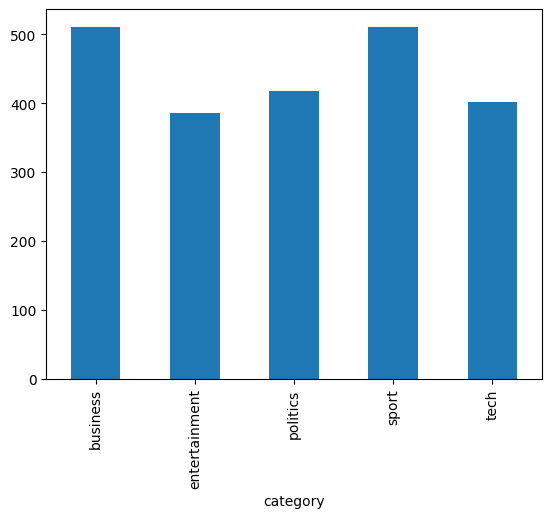

In [4]:
# il dataset è formato da 2225 sample contenenti aricoli della BBC
# suddivisi in 5 categorie in base al loro topic

print('n sample -> '+str(len(df)))
labels = set(df['category'])
print('categories -> '+str(labels)+'['+str(len(labels))+']')
print(df['category'].value_counts())
df.groupby(['category']).size().plot.bar()

In [5]:
labels_dict = {
    'business': 0,
    'politics': 1,
    'tech': 2,
    'sport': 3,
    'entertainment': 4
}

In [6]:
df['labels'] = df.apply(lambda row: labels_dict[row.category], axis = 1)

In [7]:
from sklearn.model_selection import train_test_split

(x_train, x_test, y_train, y_test) = train_test_split(
    df['text'], df['labels'], test_size=0.2, random_state=17)

(x_train, x_val, y_train, y_val) = train_test_split(
    x_train, y_train, test_size=0.1, random_state=17)

# sarebbe uno split 72, 8, 20 per avere lo stesso test dell'altra volta

In [8]:
nltk.download('punkt')
nltk.download('stopwords')

class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, y, stopwords):

        if stopwords:
            tokens_litt = [nltk.word_tokenize(text, language='english') for text in list(x)]
            # for text in list(x)]
            text_clean = []
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w for w in sentence if not w.lower() in nltk.corpus.stopwords.words("english")]))
                # in nltk.corpus.stopwords.words("english")]))
        else:
            tokens_litt = [nltk.word_tokenize(text, language='english') for text in list(x)]
            # for text in list(x)]
            text_clean = []
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                sentence_clean = ' '.join([w for w in sentence])
                text_clean.append(sentence_clean)
            # ogni token è separato dall'altro con uno spazio
        self.texts = [text for text in text_clean]
        self.labels = [torch.tensor(label) for label in y]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_labels = self.get_batch_labels(idx)

        return batch_texts, batch_labels

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
hyperparameters = {
    "epochs": 5,
    "learning_rate": 1e-3,
    "batch_size": 64,
    "dropout": 0.1,
    "stopwords": False,
    "layers": 1,
    "h_dim": 300,
    "bilstm": True,
    "patience": 5,
    "min_delta": 0.01
}

In [13]:
#creare dataset e mapping delle labels

train_dataset = Dataset(x_train, y_train, hyperparameters["stopwords"])
val_dataset = Dataset(x_val, y_val, hyperparameters["stopwords"])
test_dataset = Dataset(x_test, y_test, hyperparameters["stopwords"])

Tokenizing ... : 100%|██████████| 445/445 [00:00<00:00, 30216.37it/s]


In [16]:
class EmbsLSTMClassifierDeep(nn.Module):

    def __init__(self, labels, lstm_layers, lstm_hdim, bilstm, dropout):
        super(EmbsLSTMClassifierDeep, self).__init__()
        self.lstm = nn.LSTM(lstm_hdim, lstm_hdim, lstm_layers,
                            bidirectional=bilstm, batch_first=True)
        if bilstm:
            lstm_output = lstm_hdim*2
        else :
            lstm_output = lstm_hdim
        self.bilstm = bilstm
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output, lstm_output),
            nn.BatchNorm1d(lstm_output),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(lstm_output, labels))

    def forward(self, input_texts):
        _output, (hn, _cn) = self.lstm(input_texts)
        if not self.bilstm:
            lstm_output = hn[-1,:,:]
        else:
            lstm_output = torch.cat((hn[-2,:,:], hn[-1,:,:]), dim=1)
        final = self.classifier(lstm_output)
        return final

In [17]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramenti della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping

        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:                                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss                      # consideriamo la loss corrente
                                                                            # come nuova loss ottimale
            self.counter = 0                                                # e azzeriamo il contatore di pazienza


In [18]:
def gen_embeddings_fast_text(tokens, ft):
    embeddings = []
    for sentence in tokens:
        emb = []
        for word in sentence:
            emb.append(torch.tensor((ft[word])))
        embeddings.append(torch.stack(emb))
    return embeddings

def get_max_len(tweets_embeddings):
    max_len = 0
    for e in tweets_embeddings:
        if e.shape[0] > max_len: max_len = e.shape[0]
    return max_len

In [19]:
def train_loop(model, dataloader, ft, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for batch_texts, batch_labels in tqdm(dataloader, desc='training set'):

        optimizer.zero_grad()

        tokens = [nltk.word_tokenize(text, language='english') for text in list(batch_texts)]
        # in list(batch_texts)]
        embeddings = gen_embeddings_fast_text(tokens, ft)
        max_len_batch = get_max_len(embeddings)
        input_embeddings =  torch.stack([torch.nn.functional.pad(x,
         (0,0,0, max_len_batch-x.shape[0])) for x in embeddings]).to(device)
        batch_labels = batch_labels.to(device)
        output = model(input_embeddings)

        # la loss è una CrossEntropyLoss, al suo interno ha la logsoftmax + negative log likelihood loss
        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

        # per calcolare l'accuracy devo generare le predizioni applicando manualmente la logsoftmax
        softmax = nn.LogSoftmax(dim=1)
        epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()

        batch_labels = batch_labels.detach().cpu()
        input_embeddings = input_embeddings.detach().cpu()
        output = output.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc

In [20]:
def test_loop(model, dataloader, ft, loss, device):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    with torch.no_grad():

        for batch_texts, batch_labels, in tqdm(dataloader, desc='dev set'):

            tokens = [nltk.word_tokenize(text, language='english') for text in list(batch_texts)]
            # list(batch_texts)]
            embeddings = gen_embeddings_fast_text(tokens, ft)
            max_len_batch = get_max_len(embeddings)
            input_embeddings =  torch.stack([torch.nn.functional.pad(x, (0,0,0,
                max_len_batch-x.shape[0])) for x in embeddings]).to(device)
            batch_labels = batch_labels.to(device)
            output = model(input_embeddings)

            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()

            softmax = nn.LogSoftmax(dim=1)
            epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()
            # .sum().item()

            batch_labels = batch_labels.detach().cpu()
            input_embeddings = input_embeddings.detach().cpu()
            output = output.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc

In [21]:
# https://fasttext.cc/docs/en/python-module.html

!pip install fasttext
!pip install huggingface-hub

# download pre-trained word vectors https://fasttext.cc/docs/en/english-vectors.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4296183 sha256=3dac68bb22003e59ce0e6468b6d34899094134d8670d0335b4214a6c8beaaa7d
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [22]:
import fasttext
import nltk
from huggingface_hub import hf_hub_download

def train_test(model,
               epochs,
               optimizer,
               device,
               train_data,
               test_data,
               batch_size,
               train_loss_fn,
               test_loss_fn=None,         # non necessariamente train e test loss devono differire
               early_stopping=None,       # posso addstrare senza early stopping
               val_data=None,       # e in questo caso non c'è validation set
               scheduler=None):           # possibile scheduler per monitorare l'andamento di un iperparametro,
                                          # tipicamente il learning rate

    train_dataloader = torch.utils.data.DataLoader(train_data,
                                        batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data,
                                                 batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data,
                                                  batch_size=batch_size)

    # check sulle funzioni di loss
    if test_loss_fn == None:
        test_loss_fn = train_loss_fn

    # liste dei valori di loss e accuracy epoca per epoca per il plot
    train_loss = []
    validation_loss = []
    test_loss = []

    train_acc = []
    validation_acc = []
    test_acc = []

    model_path = hf_hub_download(repo_id="facebook/fasttext-en-vectors",
                                 filename="model.bin")
    ft = fasttext.load_model(model_path)

    # Ciclo di addestramento con early stopping
    for epoch in tqdm(range(1,epochs+1)):

        epoch_train_loss, epoch_train_acc = train_loop(model, train_dataloader,
                                        ft, train_loss_fn, optimizer, device)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc/len(train_data))

        # validation se è presente la callback di early stopping
        if early_stopping != None:
                epoch_validate_loss, epoch_validate_acc = test_loop(model,
                                    val_dataloader, ft, test_loss_fn, device)
                validation_loss.append(epoch_validate_loss)
                validation_acc.append(epoch_validate_acc/len(val_data))

        # test
        epoch_test_loss, epoch_test_acc = test_loop(model, test_dataloader,
                                                ft, test_loss_fn, device)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc/len(test_data))

        val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} ' if early_stopping != None else ' '
        # if early_stopping != None else ' '
        val_acc_str = f'Validation accuracy: {(epoch_validate_acc/len(val_data)):6.4f} ' if early_stopping != None else ' '
        # len(val_data)):6.4f} ' if early_stopping != None else ' '

        print(f"\nTrain loss: {epoch_train_loss:6.4f} {val_loss_str}Test loss: {epoch_test_loss:6.4f}")
        # len(val_data)):6.4f} ' if early_stopping != None else ' '
        print(f"Train accuracy: {(epoch_train_acc/len(train_data)):6.4f} {val_acc_str}Test accuracy: {(epoch_test_acc/len(test_data)):6.4f}")
        # {val_acc_str}Test accuracy: {(epoch_test_acc/len(test_data)):6.4f}")

        # early stopping
        if early_stopping != None:
                early_stopping(epoch_validate_loss)
                if early_stopping.early_stop:
                    break

    return train_loss, validation_loss, test_loss, train_acc, validation_acc, test_acc
    # validation_acc, test_acc

In [23]:
# Acquisiamo il device su cui effettueremo il training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = EmbsLSTMClassifierDeep(len(labels_dict),
                               hyperparameters["layers"],
                               hyperparameters["h_dim"],
                               #hyperparameters["bilstm"],
                               False,
                               hyperparameters["dropout"]).to(device)
print(model)

# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in model.parameters())
print(f"Numbero totale dei parametri: {total_params}")

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])

# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'],
                               min_delta=hyperparameters['min_delta'])

Using cuda device
EmbsLSTMClassifierDeep(
  (lstm): LSTM(300, 300, num_layers=3, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=300, out_features=300, bias=True)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=5, bias=True)
  )
)
Numbero totale dei parametri: 2259605


In [24]:
# Routine di addestramento
train_loss, validation_loss, test_loss, train_acc, validation_acc, test_acc = train_test(model,
                                                #hyperparameters['epochs'],
                                                10,
                                                optimizer,
                                                device,
                                                train_dataset,
                                                test_dataset,
                                                hyperparameters['batch_size'],
                                                criterion,
                                                criterion,
                                                early_stopping,
                                                val_dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.bin:   0%|          | 0.00/7.24G [00:00<?, ?B/s]

training set: 100%|██████████| 51/51 [00:34<00:00,  1.49it/s]

dev set: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

 10%|█         | 1/10 [00:44<06:40, 44.48s/it]


Train loss: 1.6120 Validation loss: 1.6004 Test loss: 1.6032
Train accuracy: 0.2366 Validation accuracy: 0.2303 Test accuracy: 0.2157



training set: 100%|██████████| 51/51 [00:31<00:00,  1.59it/s]

dev set: 100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

 20%|██        | 2/10 [01:26<05:44, 43.02s/it]


Train loss: 1.6006 Validation loss: 1.6180 Test loss: 1.6014
Train accuracy: 0.2222 Validation accuracy: 0.2416 Test accuracy: 0.2202



training set: 100%|██████████| 51/51 [00:33<00:00,  1.54it/s]

dev set: 100%|██████████| 6/6 [00:02<00:00,  2.25it/s]

 30%|███       | 3/10 [02:09<05:01, 43.14s/it]


Train loss: 1.6129 Validation loss: 1.6500 Test loss: 1.6687
Train accuracy: 0.2360 Validation accuracy: 0.1685 Test accuracy: 0.1820



training set: 100%|██████████| 51/51 [00:31<00:00,  1.61it/s]

dev set: 100%|██████████| 6/6 [00:02<00:00,  2.26it/s]

 40%|████      | 4/10 [02:51<04:15, 42.55s/it]


Train loss: 1.6085 Validation loss: 1.6885 Test loss: 1.6731
Train accuracy: 0.2453 Validation accuracy: 0.2303 Test accuracy: 0.2180



training set: 100%|██████████| 51/51 [00:31<00:00,  1.61it/s]

dev set: 100%|██████████| 6/6 [00:02<00:00,  2.27it/s]

 50%|█████     | 5/10 [03:32<03:30, 42.16s/it]


Train loss: 1.6185 Validation loss: 1.7697 Test loss: 1.8371
Train accuracy: 0.2341 Validation accuracy: 0.2247 Test accuracy: 0.2180



training set: 100%|██████████| 51/51 [00:31<00:00,  1.60it/s]

dev set: 100%|██████████| 6/6 [00:02<00:00,  2.02it/s]

 50%|█████     | 5/10 [04:14<04:14, 50.97s/it]


Train loss: 1.5917 Validation loss: 1.8592 Test loss: 1.8072
Train accuracy: 0.2416 Validation accuracy: 0.2416 Test accuracy: 0.2247
Early stop!


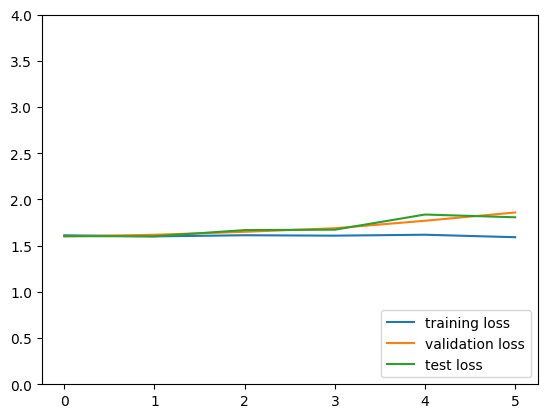

In [25]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.plot(test_loss, label='test loss')
plt.legend(loc='lower right')
plt.ylim(0,4)
plt.show()

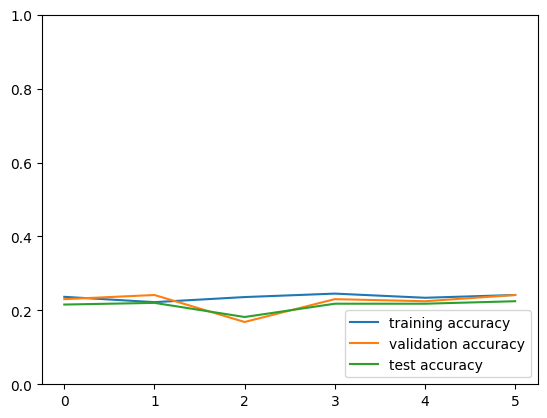

In [26]:
plt.plot(train_acc, label='training accuracy')
plt.plot(validation_acc, label='validation accuracy')
plt.plot(test_acc, label='test accuracy')
plt.legend(loc='lower right')
plt.ylim(0,1)
plt.show()